In [52]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import time

In [30]:
env = gym.make('Blackjack-v1', natural=True, sab=False)


# ЧАСТЬ 1

### 1. Оцениваем выигрыш по простейшей стратегии из задания: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit.

In [31]:
# функция, генерирующая эпизод и возвращающая награду (на данный момент простейшая функция, без данных для обучения)
def run_episode(env):
    (player_sum, dealer_sum, us_ace), _ = env.reset()
    while player_sum < 19:
        ((player_sum, dealer_sum, us_ace), reward, trmn, _,_) = env.step(action=1)
        if trmn: # > 21
            return reward
    ((player_sum, dealer_sum, us_ace), reward, trmn, _,_) = env.step(action=0)
    return reward

In [39]:
t = time.time()
rewards = []
for i in range(1000000):
    rewards.append(run_episode(env))
print(time.time() - t)    

61.22091817855835


In [40]:
aver_reward = sum(rewards) / len(rewards)
print(aver_reward)

-0.1797055


### Итак, в среднем при такой стратегии казино выигрывает 0.18 очков

### 2. Строим модель MC control

In [43]:
# создаем словарь значение Q, которую будем обновлять и по которой будет определяться стратегия
def reset_Q():
    Q_vals = dict()
    for i in range(2, 32):
        for j in range(1, 11):
            for k in range(2):
                Q_vals[(i,j,k)] = {}
                for act in actions:
                    Q_vals[(i,j,k)][act] = {}
                    if i == 21 and act == 0: # случай usable ace
                        #Q_vals[(i,j,k)][act] = {}
                        Q_vals[(i,j,k)][act]["value"] = 1
                        Q_vals[(i,j,k)][act]["counts"] = 1

                    else:

                        Q_vals[(i,j,k)][act]["value"] = 0
                        Q_vals[(i,j,k)][act]["counts"] = 0
       
    return Q_vals

In [44]:
# определяем действие по стратегии (используем eps мягкую стратегию для исследования)
def action_step(state):
    if np.random.rand() < eps:
        action = np.random.choice(actions)
    else:
        v = -1e9
        for a in Q_vals[state]:
            #print("a = %d" %a)
            if Q_vals[state][a]["value"] > v:
                action = a
                v = Q_vals[state][a]["value"]
    #print(action)            
    return action

In [45]:
# генерируем эпизод
def run_episode(env):
    #states = list of ((player_sum, dealer_sum, usable_ace))
    states = []
    rewards = [0]
    ep_actions = []
    trmn = False
    #(player_sum, dealer_sum, us_ace), reward = env.reset()
    state, _ = env.reset()
    states.append(state)
    action = action_step(state)
    ep_actions.append(action)
    
    for i in range(100):
        (state, reward, trmn,_,_) = env.step(action=action)
        action = action_step(state)
        states.append(state)
        rewards.append(reward)
        ep_actions.append(action)
        if trmn:
            break        

    return [states, rewards, ep_actions]

In [46]:
# обновляем среднее значение в состоянии [state][action]
def update_unit(state, action, g): 
    #print("in update unit")
    #print(state, action)
    v_old = Q_vals[state][action]["value"]
    size = Q_vals[state][action]["counts"]
    v_new = (size * v_old + g) / (size + 1)
    size += 1
    Q_vals[state][action]["value"] = v_new
    Q_vals[state][action]["counts"] = size

In [47]:
# По сгенерированному эпизоду обновляем значения с словаре Q
def update_returns_actions(states, rewards, actions, n_iter):
    all_rewards[n_iter] = rewards[-1]
    #all_rewards.append(rewards[-1])
    g = 0
    #print("len of states = %d" %len(states))
    #print(states)
    #print(actions)
    #print(rewards)
    for t in range(len(states)-2, -1, -1):
        #print()
        g = g * gamma + rewards[t+1]
        update_unit(states[t], actions[t], g)

In [54]:
# Подсчет среднего значения дохода на отрезках вида [i-50000: i+50000]
def calc_mov_av(all_rewards, nbins=41, width=100000):
    aver_rewards = []
    
    inds = np.linspace(0, len(all_rewards), nbins)
    inds = inds[1:-1]
    inds = inds.astype("int")
    #print(inds)
    for i in inds:
        aver_rewards.append(np.mean(all_rewards[i-int(width/2):i+int(width/2)]))
    return [inds, aver_rewards]   

In [63]:
actions = [0, 1]
gamma = 0.9
eps = 0.01
Q_vals = reset_Q()

In [64]:
# Посмотрим на обучение для разных значений eps
N = 2000000
all_rewards = [None for i in range(N)]
t = time.time()

for n in range(N):
    [ep_states, ep_rewards, ep_actions] = run_episode(env)
    
    update_returns_actions(ep_states, ep_rewards, ep_actions, n)
    
    if n % 100000 == 0:
        print("iter %d" %n)
        print("elapsed time %f" %(time.time() - t))
print("total elapsed time %f" %(time.time() - t)) 

iter 0
elapsed time 0.000360
iter 100000
elapsed time 7.807009
iter 200000
elapsed time 15.356611
iter 300000
elapsed time 22.570834
iter 400000
elapsed time 29.842690
iter 500000
elapsed time 37.393219
iter 600000
elapsed time 44.913477
iter 700000
elapsed time 52.773949
iter 800000
elapsed time 60.836850
iter 900000
elapsed time 68.286895
iter 1000000
elapsed time 76.036296
iter 1100000
elapsed time 84.047446
iter 1200000
elapsed time 92.189212
iter 1300000
elapsed time 99.986137
iter 1400000
elapsed time 108.430436
iter 1500000
elapsed time 115.964533
iter 1600000
elapsed time 123.628905
iter 1700000
elapsed time 130.995191
iter 1800000
elapsed time 138.858537
iter 1900000
elapsed time 146.909296
total elapsed time 154.959636


In [56]:
#inds, aver_rewards_eps_01 = calc_mov_av(all_rewards)

In [61]:
#inds, aver_rewards_eps_005 = calc_mov_av(all_rewards)

In [65]:
inds, aver_rewards_eps_001 = calc_mov_av(all_rewards)

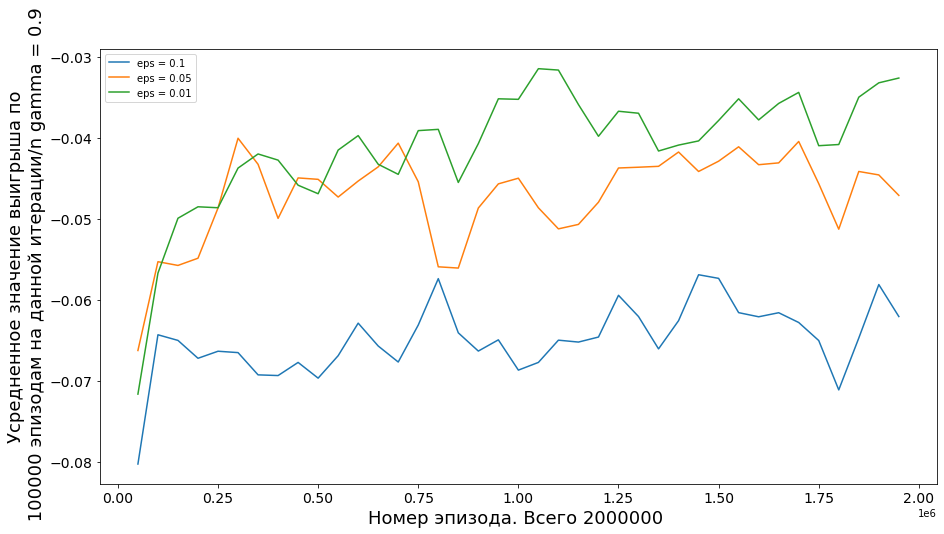

In [66]:
plt.figure(figsize=(15,8))
plt.plot(inds, aver_rewards_eps_01, label="eps = 0.1")
plt.plot(inds, aver_rewards_eps_005, label="eps = 0.05")
plt.plot(inds, aver_rewards_eps_001, label="eps = 0.01")
plt.xlabel('Номер эпизода. Всего 2000000 ', fontsize=18)
plt.ylabel('Усредненное значение выигрыша по\n 100000 эпизодам на данной итерации/n gamma = 0.9', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.show()

### Итак, в зависимости от eps казино выигрывает в среднем 0.04 - 0.06 очков за игру vs 0.18 очков при простой стратегии из п.1.

## ЧАСТЬ 2

### Добавление действия double

### Для реализации воспользуемся исходным кодом для класса BlackjackEnv и немного его переделаем. А именно, добавим множитель self.mult, изначально равный 1, а в случае, если action=2 (данная цифра будет обозначать действие double ), self.mult=2. В случае конца эпизода будем возвращать reward*self.mult
(код взят с https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py)